In [3]:
import numpy as np
import astropy.units as u
import matplotlib.pyplot as plt
from astropy.wcs import WCS
import numpy as np
import astropy.io.fits as fits
from matplotlib import pyplot as plt
from astropy.coordinates import SkyCoord
from astropy import units as units
import astropy.units as u
from astropy.coordinates import SkyCoord
from tqdm import tqdm
from astropy.coordinates import SkyCoord, Galactic, CartesianRepresentation,CartesianDifferential

In [4]:
l = 122.93314*u.deg #theta_0 in Soderblom
d = 27.13 *u.deg    #delta_NGP in Soderblom
a = 192.85 *u.deg   #alpha_NGP in Soderblom

In [5]:
T_1 = np.array([
    [np.cos(l), np.sin(l), 0],
    [np.sin(l), -np.cos(l), 0],
    [0, 0, 1]
])

T_2 = np.array([
    [-np.sin(d), 0, np.cos(d)],
    [0, -1, 0],
    [np.cos(d), 0, np.sin(d)]
])

T_3 = np.array([
    [np.cos(a), np.sin(a), 0],
    [np.sin(a), -np.cos(a), 0],
    [0, 0, 1]
])

T = T_1@T_2@T_3

In [6]:
print(T)

[[-0.055045   -0.87342181 -0.48384335]
 [ 0.49405689 -0.4449249   0.74696025]
 [-0.86768533 -0.19792971  0.45601096]]


In [8]:
ra=49.9958333 *u.deg #RA and DEC of tadpole
dec=65.6522   *u.deg #Previously I had the values in A as alpha_NGP and delta_NGP respectivley

In [9]:
A = np.array([
    [np.cos(ra)*np.cos(dec), -np.sin(ra), -np.cos(ra)*np.sin(dec)],
    [np.sin(ra)*np.cos(dec), np.cos(ra), -np.sin(ra)*np.sin(dec)],
    [np.sin(dec), 0, np.cos(dec)]
])
print(A)

[[ 0.26502795 -0.7659977  -0.5856686 ]
 [ 0.31580137  0.64284332 -0.69786959]
 [ 0.91105965  0.          0.41227457]]


In [10]:
B=T@A
print(B)

[[-0.73122642 -0.51930903  0.44229634]
 [ 0.67095634 -0.66446344  0.32909866]
 [ 0.12298584  0.53740717  0.83430691]]


In [11]:
parallax = 4.0589/1000
RA_pm = 11.6/1000
DE_pm = -16.96/1000
radial_vel = -3.4
k=4.74057

In [12]:
dl_dt=[]
db_dt=[]
U_LSR=[]
V_LSR=[]
W_LSR=[]
radial_bike=[] #velocity -> velo -> bike (french)

sco = SkyCoord(ra=49.9958333*u.degree, dec =65.6522*u.degree, distance=233.6*u.pc)
gco = sco.transform_to(Galactic())
gco = gco.represent_as(CartesianRepresentation)

for i in tqdm(range(0, 10000)):
    U_s=(np.random.normal(loc=7.01, scale=0.2, size=1))[0]
    V_s=(np.random.normal(loc=10.13, scale=0.12, size=1))[0]
    W_s=(np.random.normal(loc=4.95, scale=0.09, size=1))[0]
    
    
    parallax = np.random.normal(loc=4.0589/1000,scale=0.3232/1000,size=1)[0]
    RA_pm = np.random.normal(loc=11.6/1000, scale=0.1494/1000,size=1)[0]
    DE_pm = np.random.normal(loc=-16.9615/1000, scale=0.2671/1000,size=1)[0]
    
    U_bar = (B@np.array([[radial_vel],[k*RA_pm/parallax],[k*DE_pm/parallax]]))[0]
    V_bar = (B@np.array([[radial_vel],[k*RA_pm/parallax],[k*DE_pm/parallax]]))[1]
    W_bar = (B@np.array([[radial_vel],[k*RA_pm/parallax],[k*DE_pm/parallax]]))[2]
    
    U = (U_bar+U_s)[0]
    V = (V_bar+V_s)[0]
    W = (W_bar+W_s)[0]
    
    U_LSR.append(U)
    V_LSR.append(V)
    W_LSR.append(W)
    
    co = Galactic(u=gco.x.value*u.pc, v=gco.y.value*u.pc, w=gco.z.value*u.pc, 
              U=U*u.km/u.s, V=V*u.km/u.s, W=W*u.km/u.s,
              representation_type=CartesianRepresentation,
              differential_type=CartesianDifferential)
    dl_dt.append(co.proper_motion[0].value)
    db_dt.append(co.proper_motion[1].value)
    radial_bike.append(co.radial_velocity.value)
    

    

  0%|                                                                                                                                       | 0/10000 [00:00<?, ?it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:46<00:00, 216.81it/s]


In [13]:
start_l = 137.45706817862768
start_b = 7.06094581066827


t = np.linspace(-4e6,0, 10000)
t2 = np.linspace(-4e6, 0, 4)

l_vec = np.mean(dl_dt)/3600000.*t+start_l
l_time = np.mean(dl_dt)/3600000*t2+start_l

b_vec = np.mean(db_dt)/3600000*t+start_b
b_time = np.mean(db_dt)/3600000*t2+start_b

l_vec_p = (np.mean(dl_dt)+np.std(dl_dt))/3600000*t+start_l
b_vec_p = (np.mean(db_dt)+np.std(db_dt))/3600000*t+start_b
l_vec_m = (np.mean(dl_dt)-np.std(dl_dt))/3600000*t+start_l
b_vec_m = (np.mean(db_dt)-np.std(db_dt))/3600000*t+start_b


In [14]:
fn = '/srv/data/chime/tadpole_cutout_Mar2024/IQUV_400_729/Q_400_729_Mar2024_tadpole_gal.fits'
hdr_chimeQ = fits.getheader(fn)
chimeQ = fits.getdata(fn)
wcs_chime = WCS(hdr_chimeQ)

fn = '/srv/data/chime/tadpole_cutout_Mar2024/IQUV_400_729/U_400_729_Mar2024_tadpole_gal.fits'
hdr_chimeU = fits.getheader(fn)
chimeU = fits.getdata(fn)

In [16]:
xpix_gal, ypix_gal = wcs_chime.celestial.wcs_world2pix(137.45706817862768,7.06094581066827, 1)
xpix_gal = np.fix(xpix_gal)
ypix_gal = np.fix(ypix_gal)
xpix_gal, ypix_gal

s=100
ymin=ypix_gal-s; ymax=ypix_gal+s; xmin=xpix_gal-s; xmax=xpix_gal+s;

In [17]:
xhead_chime,         yhead_chime = wcs_chime.celestial.wcs_world2pix(137.08,7.2, 1)
xhead_chime = int(xhead_chime)
yhead_chime = int(yhead_chime)


xtail_chime,         ytail_chime = wcs_chime.celestial.wcs_world2pix(134,6.6, 1)
xtail_chime = int(xtail_chime)
ytail_chime = int(ytail_chime)

xoff_chime,         yoff_chime = wcs_chime.celestial.wcs_world2pix(135,9.5, 1)
xoff_chime = int(xoff_chime)
yoff_chime = int(yoff_chime)



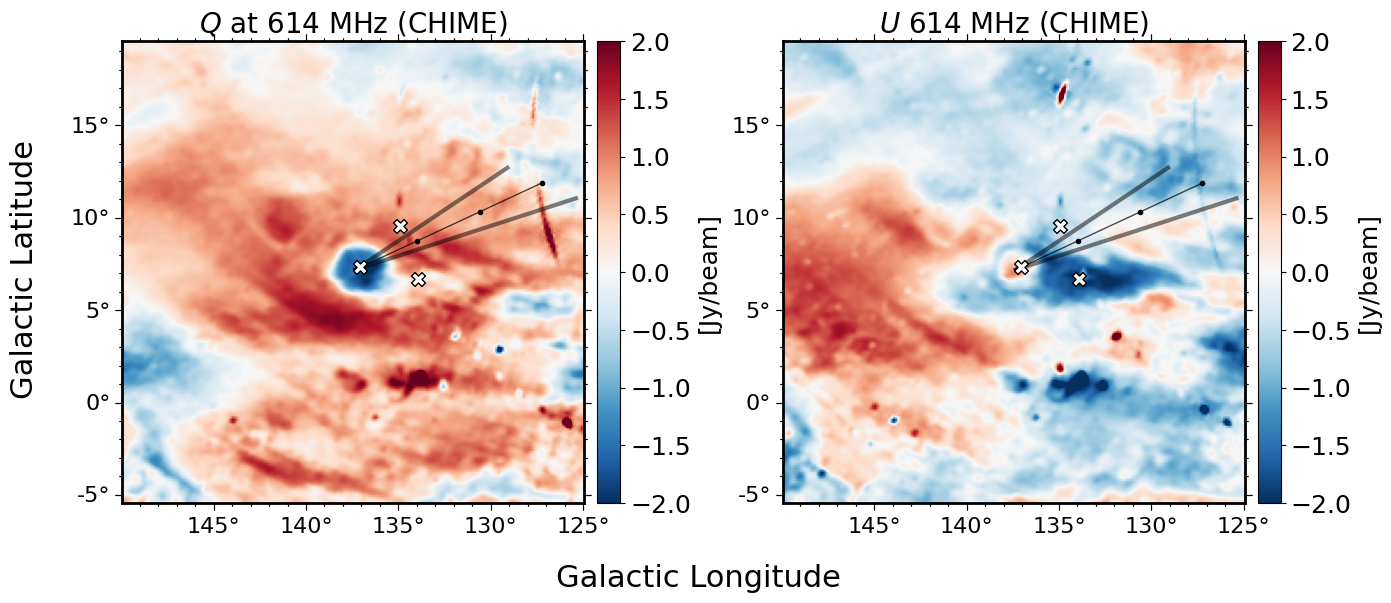

In [19]:
fig = plt.figure(figsize=(14*1.2, 5*1.2))

#--------------------------------------------------------------------- CHIME Plots
#----------------------------------------------------------------- U
ax = fig.add_subplot(122, projection=wcs_chime.celestial)  # Changed from 231 to 321
im = ax.imshow(chimeU[297], cmap='RdBu_r', vmin=-2, vmax=2)
#ax.scatter(xpix_gal, ypix_gal,       c='white', s=100, marker='x', zorder=10)
ax.scatter(xhead_chime, yhead_chime,c='white', s=100, marker='X',edgecolor='black',zorder=10)
ax.scatter(xtail_chime, ytail_chime,c='white', s=100, marker='X',edgecolor='black',zorder=10)
ax.scatter(xoff_chime, yoff_chime,  c='white', s=100, marker='X',edgecolor='black',zorder=10)
ax.set_ylim(ymin, ymax)
ax.set_xlim(xmin, xmax)
ax.set_title("$U$ 614 MHz (CHIME)", fontsize=20)
ax.set_aspect(np.abs(wcs_chime.wcs.cdelt[1] / wcs_chime.wcs.cdelt[0]))
ax.set_xlabel(" ", fontsize=20)
ax.set_ylabel(" ", fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=16, zorder=30, length=5)


ax.coords[0].display_minor_ticks(True)
ax.coords[1].display_minor_ticks(True)

ax.coords.frame.set_linewidth(2)

ax.plot(wcs_chime.wcs_world2pix(l_vec, 1, 1, 1)[0], wcs_chime.wcs_world2pix(1, b_vec, 1, 1)[1],
        color='black',zorder=1,linewidth=1, label="proper motion" "\n" "path", ls='-', alpha=0.7)
ax.scatter(wcs_chime.wcs_world2pix(l_time[:len(l_time)-1], 1, 1, 1)[0], wcs_chime.wcs_world2pix(1, b_time[:len(l_time)-1], 1, 1)[1],
        color='black',zorder=1,linewidth=1, label="proper motion" "\n" "path", marker='.')

ax.plot(wcs_chime.wcs_world2pix(l_vec_p, 1, 1, 1)[0], wcs_chime.wcs_world2pix(1, b_vec_p, 1, 1)[1],
        color='black',zorder=1,linewidth=3, alpha=0.5, label="proper motion" "\n" "path", ls='-')

ax.plot(wcs_chime.wcs_world2pix(l_vec_m, 1, 1, 1)[0], wcs_chime.wcs_world2pix(1, b_vec_m, 1, 1)[1],
        color='black',zorder=1,linewidth=3, alpha=0.5, label="proper motion" "\n" "path", ls='-')




cbar = plt.colorbar(im, ax=ax, shrink=1, pad=0.02)
cbar.ax.tick_params(labelsize=18)
cbar.set_label("[Jy/beam]", fontsize=18)

#----------------------------------------------------------------- Q
ax = fig.add_subplot(121, projection=wcs_chime.celestial)  # Changed from 231 to 321
im = ax.imshow(chimeQ[297], cmap='RdBu_r', vmin=-2, vmax=2)
#ax.scatter(xpix_gal, ypix_gal,       c='white', s=100, marker='x', zorder=10)
ax.scatter(xhead_chime, yhead_chime, c='white', s=100, marker='X',edgecolor='black',zorder=10)
ax.scatter(xtail_chime, ytail_chime, c='white', s=100, marker='X',edgecolor='black',zorder=10)
ax.scatter(xoff_chime, yoff_chime,   c='white', s=100, marker='X',edgecolor='black',zorder=10)
ax.set_ylim(ymin, ymax)
ax.set_xlim(xmin, xmax)
ax.set_title("$Q$ at 614 MHz (CHIME)", fontsize=20)
ax.set_aspect(np.abs(wcs_chime.wcs.cdelt[1] / wcs_chime.wcs.cdelt[0]))
ax.set_xlabel(" ", fontsize=20)
ax.set_ylabel(" ", fontsize=20)


ax.tick_params(axis='both', which='major', labelsize=16, zorder=30, length=5)
ax.coords[0].display_minor_ticks(True)
ax.coords[1].display_minor_ticks(True)



ax.plot(wcs_chime.wcs_world2pix(l_vec, 1, 1, 1)[0], wcs_chime.wcs_world2pix(1, b_vec, 1, 1)[1],
        color='black',zorder=1,linewidth=1, label="proper motion" "\n" "path", ls='-', alpha=0.7)
ax.scatter(wcs_chime.wcs_world2pix(l_time[:len(l_time)-1], 1, 1, 1)[0], wcs_chime.wcs_world2pix(1, b_time[:len(l_time)-1], 1, 1)[1],
        color='black',zorder=1,linewidth=1, label="proper motion" "\n" "path", marker='.')

ax.plot(wcs_chime.wcs_world2pix(l_vec_p, 1, 1, 1)[0], wcs_chime.wcs_world2pix(1, b_vec_p, 1, 1)[1],
        color='black',zorder=1,linewidth=3, alpha=0.5, label="proper motion" "\n" "path", ls='-')

ax.plot(wcs_chime.wcs_world2pix(l_vec_m, 1, 1, 1)[0], wcs_chime.wcs_world2pix(1, b_vec_m, 1, 1)[1],
        color='black',zorder=1,linewidth=3, alpha=0.5, label="proper motion" "\n" "path", ls='-')



ax.coords.frame.set_linewidth(2)

cbar = plt.colorbar(im, ax=ax, shrink=1, pad=0.02)
cbar.ax.tick_params(labelsize=18)
cbar.set_label("[Jy/beam]", fontsize=18)

#--------------------------------------------------------------------- Universal
fig.supylabel('Galactic Latitude', fontsize=22, x=0.1)
fig.supxlabel('Galactic Longitude', fontsize=22, y=-.04, x=0.51)

fig.subplots_adjust(wspace=0.03)

plt.savefig('/srv/nmohamme/notebooks/Fall2023/Paper_update/figures_Mar2024/fig2.pdf', bbox_inches='tight', pad_inches=0.1)